In [1]:
# If you are a developer, you may want to reload the packages on the fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

# import standard python libraries
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 96
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, subprocess
from scipy.stats import bootstrap
from textwrap import wrap
from matplotlib import font_manager
font_dirs = ["/home/izhegalova/fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
susielu = ["#b84873", "#6dbc5f","#5a3789","#bdab3d","#6d80d8","#bd7635","#bf68b8","#46c19a","#ba4b41","#71883b"]
sns.set_theme(context="paper", style='whitegrid', palette=susielu, font="Arial")

os.chdir('/home/izhegalova/ecoli_microc')

# import libraries for biological data analysis
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe as bf
import cooltools
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting

In [2]:
# %% create bins
resolution = 10
clr = cooler.Cooler('data/wt.combined.MG1655.mapq30.10.mcool::resolutions/' + str(resolution))
clr_44 = cooler.Cooler('data/wt_44C.combined.MG1655.mapq30.10.mcool::resolutions/' + str(resolution))
df_chromsizes = clr.chromsizes
bins = cooler.binnify(df_chromsizes, resolution)
bins.chrom = bins.chrom.astype(str)
fasta_records = bf.load_fasta('data/genome.fasta')
view_df_chromsizes = clr.chromsizes.reset_index()
view_df_chromsizes.columns = ['chrom', 'end']
view_df_chromsizes['start'] = 0
view_df_chromsizes['name'] = 'NC_000913.3'
view_df_chromsizes = view_df_chromsizes[['chrom', 'start', 'end', 'name']]

In [3]:
expected = cooltools.expected_cis(clr, view_df=view_df_chromsizes,
                                nproc=32, 
                                chunksize=100_000,
                                ignore_diags=2) #, median=True
expected_44 = cooltools.expected_cis(clr_44, view_df=view_df_chromsizes,
                                nproc=32, 
                                chunksize=100_000,
                                ignore_diags=2) #, median=True

INFO:root:creating a Pool of 32 workers
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
INFO:root:creating a Pool of 32 workers
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


# Response to Heat

In [5]:
df_go = pd.read_table('data/All-genes-of-E.-coli-K-12-substr.-MG1655-GOterms.txt')
df_go = df_go.loc[:,[ 'Accession-1', 'GO terms (biological process)', 
                     'GO terms (cellular component)', 'GO terms (molecular function)']]
df_go.dropna(subset=['GO terms (biological process)', 
                  'GO terms (cellular component)', 'GO terms (molecular function)'], 
          inplace=True)
df_go.drop_duplicates(inplace=True)
df_go.head()

,Accession-1,GO terms (biological process),GO terms (cellular component),GO terms (molecular function)
138,b4661,GO:0009297 // GO:0055085 // GO:0043711,GO:0016020 // GO:0009279,GO:0015473
173,b4623,GO:0006313 // GO:0015074 // GO:0032196 // GO:0...,GO:0005829,GO:0004803 // GO:0003676 // GO:0003677
177,b4618,GO:0098656 // GO:0006974 // GO:0022611 // GO:0...,GO:0005886 // GO:0016020,GO:0005253
193,b4602,GO:0071456,GO:0005886 // GO:0070069 // GO:0016020,GO:0005515
195,b4599,GO:0010960 // GO:0010350,GO:0005886 // GO:0016020,GO:0005515


In [6]:
df_go = (df_go.set_index(['Accession-1','GO terms (biological process)', 
                  'GO terms (cellular component)'])
   .apply(lambda x: x.str.split(' // ').explode())
   .reset_index())   
df_go = (df_go.set_index(['Accession-1','GO terms (molecular function)', 
                  'GO terms (cellular component)'])
   .apply(lambda x: x.str.split(' // ').explode())
   .reset_index())  
df_go = (df_go.set_index(['Accession-1','GO terms (biological process)', 
                  'GO terms (molecular function)'])
   .apply(lambda x: x.str.split(' // ').explode())
   .reset_index()) 
df_go_melted = pd.melt(df_go, id_vars='Accession-1')
df_go_melted.drop_duplicates(inplace=True)
df_go_melted.columns = ['Accession-1', 'group', 'GO']
df_go_melted.head()

,Accession-1,group,GO
0,b4661,GO terms (biological process),GO:0009297
2,b4661,GO terms (biological process),GO:0055085
4,b4661,GO terms (biological process),GO:0043711
6,b4623,GO terms (biological process),GO:0006313
7,b4623,GO terms (biological process),GO:0015074


In [4]:
TU_df = pd.read_csv('data/Operon_TU_counts.tsv', sep='\t', index_col=0)
TU_df.columns = ['chrom', 'start', 'end', 'TU_name', 'strand', 'GeneID', 'genes', 'ngenes', 
                 'protein_codin', 
                 'sigma', 'nascent_wt',
                 'totat_wt', 'nascent_wt44', 'totat_wt44']
TU_df['chrom'] = 'NC_000913.3'
TU_df['length'] = TU_df.end - TU_df.start
bin_labels_4 = ['short', '25-50%', '50-75%', 'long']
TU_df['length_group'] = pd.qcut(TU_df['length'], 4, labels=False)
TU_df['lengthBool_group'] = np.where(TU_df['length'] > TU_df.length.median(), 'long', 'short')

bin_labels_4 = ['bottom 50%', '50-75%', '75-90%', '>90%']
TU_df['nascentCust_group'] = pd.qcut(TU_df['nascent_wt'], 
                                          q=[0, .5, .75, .9, 1],
                                          labels=bin_labels_4)
TU_df['HeatResponsegroup'] = 'no'
TU_df.head()

,chrom,start,end,TU_name,strand,GeneID,genes,ngenes,protein_codin,sigma,nascent_wt,totat_wt,nascent_wt44,totat_wt44,length,length_group,lengthBool_group,nascentCust_group,HeatResponsegroup
0,NC_000913.3,1004768,1005778,pyrD,+,operon_tu1,pyrD,1,True,sigma70,0,49,0,93,1010,1,short,bottom 50%,no
1,NC_000913.3,1005952,1006494,zapC,+,operon_tu2,zapC,1,True,unknown,3,296,19,783,542,0,short,50-75%,no
2,NC_000913.3,1006491,1007600,ycbX,-,operon_tu3,ycbX,1,True,unknown,0,146,2,122,1109,2,long,bottom 50%,no
3,NC_000913.3,1007844,1011871,rlmL-uup,+,operon_tu4,rlmL;uup,2,True,unknown,1,341,22,901,4027,3,long,bottom 50%,no
4,NC_000913.3,1012001,1015459,pqiABC,+,operon_tu5,pqiA;pqiB;pqiC,3,True,sigma38,8,318,19,818,3458,3,long,75-90%,no


## HeatResponse - GO

In [8]:
df_genes = pd.read_table('data/All-genes-of-E.-coli-K-12-substr.-MG1655---GO.txt')
df = pd.merge(df_go_melted, df_genes, on='Accession-1', suffixes=['_go', '_gene'])
bool_list = df['GO'].str.contains('GO:0009408')
df_heatResponse = df.loc[bool_list,:]
df_heatResponse.head()

,Accession-1,group,GO,Gene Name,Product,GO terms (biological process),GO terms (cellular component),GO terms (molecular function),UniProt,Synonyms
41,b4539,GO terms (biological process),GO:0009408,yoeB,ribosome-dependent mRNA interferase toxin YoeB,negative regulation of DNA-templated transcrip...,toxin-antitoxin complex // cytosol,RNA binding // nuclease activity // endonuclea...,P69348,NaN
671,b4175,GO terms (biological process),GO:0009408,hflC,regulator of FtsH protease,response to heat,plasma membrane protein complex // membrane //...,protein binding,P0ABC3,hflA
672,b4174,GO terms (biological process),GO:0009408,hflK,regulator of FtsH protease,response to heat,plasma membrane protein complex // membrane //...,protein binding,P0ABC7,hslY // hflA
677,b4173,GO terms (biological process),GO:0009408,hflX,ribosome rescue factor HflX,viral latency // peptidyl-serine autophosphory...,cytoplasm // cytosol,metal ion binding // nucleotide binding // ATP...,P25519,hslX // hflA
780,b4143,GO terms (biological process),GO:0009408,groL,chaperonin GroEL,mitochondrial unfolded protein response // pos...,membrane // cytoplasm // GroEL-GroES complex /...,protein-folding chaperone binding // ATP-depen...,P0A6F5,groEL // mopA


In [9]:
heatResponse_list = df_heatResponse['Gene Name'].tolist()
TU_df_splittedGenes = (TU_df.loc[:,['TU_name', 'genes']].set_index(['TU_name'])
       .apply(lambda x: x.str.split(';').explode())
       .reset_index()) 
TU_name_list = TU_df_splittedGenes.TU_name[TU_df_splittedGenes.genes.isin(heatResponse_list)].tolist()
TU_df.loc[TU_df.TU_name.isin(TU_name_list),'HeatResponsegroup'] = 'GO_HR'
TU_df.head()

,chrom,start,end,TU_name,strand,GeneID,genes,ngenes,protein_codin,sigma,nascent_wt,totat_wt,nascent_wt44,totat_wt44,length,length_group,lengthBool_group,nascentCust_group,HeatResponsegroup
0,NC_000913.3,1004768,1005778,pyrD,+,operon_tu1,pyrD,1,True,sigma70,0,49,0,93,1010,1,short,bottom 50%,no
1,NC_000913.3,1005952,1006494,zapC,+,operon_tu2,zapC,1,True,unknown,3,296,19,783,542,0,short,50-75%,no
2,NC_000913.3,1006491,1007600,ycbX,-,operon_tu3,ycbX,1,True,unknown,0,146,2,122,1109,2,long,bottom 50%,no
3,NC_000913.3,1007844,1011871,rlmL-uup,+,operon_tu4,rlmL;uup,2,True,unknown,1,341,22,901,4027,3,long,bottom 50%,no
4,NC_000913.3,1012001,1015459,pqiABC,+,operon_tu5,pqiA;pqiB;pqiC,3,True,sigma38,8,318,19,818,3458,3,long,75-90%,no


## Sigma32

In [5]:
sigma32_HR_TU_df = TU_df.query('lengthBool_group == "long" and sigma == "sigma32"')
sigma32_HR_TU_df['HeatResponsegroup'] = 'sigma32_HR'

## FC TU

<Axes: ylabel='FC'>

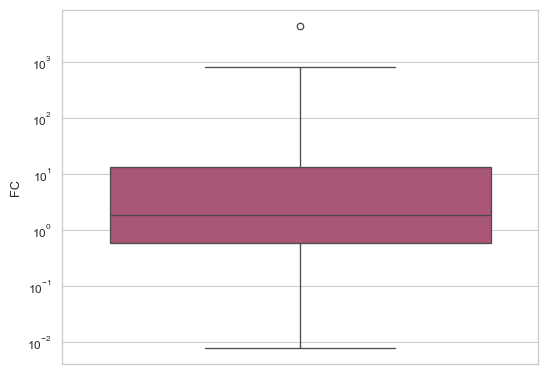

In [12]:
TU_df['nascent_wt_CPM'] = TU_df.nascent_wt / 4258792 * 1000000
TU_df['nascent_wt44_CPM'] = TU_df.nascent_wt44 / 6936811 * 1000000
TU_df['FC'] = TU_df.nascent_wt44_CPM / (TU_df.nascent_wt_CPM + 0.01)
sns.boxplot(data=TU_df,y='FC',log_scale=True)

In [13]:
wt44_thr = np.quantile(TU_df.nascent_wt44, 0.95)
FC_HR_TU_df = TU_df.query('FC > 4 and lengthBool_group == "long" and nascent_wt44 > @wt44_thr')
FC_HR_TU_df['HeatResponsegroup'] = 'FC_HR'

## Hi-C heatResponse

In [7]:
clr.info['sum']

662252537

In [6]:
clr_44.info['sum']

664713703

In [8]:
HR_TU_df = pd.concat([TU_df.query('HeatResponsegroup != "no"'), FC_HR_TU_df, sigma32_HR_TU_df])
HR_TU_df.HeatResponsegroup.value_counts()

NameError: name 'FC_HR_TU_df' is not defined

In [134]:
HR_TU_df.length.median()

2015.0

In [15]:
flank = 2000
pup_median = coolpup.pileup(clr_44, HR_TU_df.query('lengthBool_group == "long"'), 
                     groupby=['HeatResponsegroup1'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     #expected_df=expected,
                     flip_negative_strand=True,
                     flank=flank, min_diag=10, nproc=32,
                    mean_bool=False)
# sns.set_theme(font_scale=2, style="ticks")
# plotpup.plot(pup,
# #              rows='lengthBool_group1', row_order=['long'],
#              cols='HeatResponsegroup1', 
#              # col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
#              score=False, cmap='fall', scale='log', sym=False,
#              vmin=0.000005, vmax=0.0005, #suitable fo rescale_flank=5, flank=10k
#              #vmin=0.000015, vmax=0.001,
#              height=5)

# plt.savefig('results/wt44_av_TU.3WaysHR.flank1.FC4.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()

/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroffset = self.clr.offset(region[0])
INFO:coolpuppy:Rescaling with rescale_flank = 1 to 401x401 pixels


{'NC_000913.3'}


INFO:coolpuppy:('NC_000913.3', 'NC_000913.3'): 92
INFO:coolpuppy:Total number of piled up windows: 92
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:2186: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pups["expected"] = pups["expected"].fillna(False)


In [16]:
flank = 2000
pup_wt = coolpup.pileup(clr, HR_TU_df.query('lengthBool_group == "long"'), 
                     groupby=['HeatResponsegroup1'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     #expected_df=expected,
                     flip_negative_strand=True,
                     flank=flank, min_diag=10, nproc=32,
                    mean_bool=False)
# sns.set_theme(font_scale=2, style="ticks")
# plotpup.plot(pup_wt,
# #              rows='lengthBool_group1', row_order=['long'],
#              cols='HeatResponsegroup1', 
#              # col_order=['bottom 50%', '50-75%', '75-90%', '>90%'],
#              score=False, cmap='fall', scale='log', sym=False,
#              vmin=0.000005, vmax=0.0005, #suitable fo rescale_flank=5, flank=10k
#              #vmin=0.000015, vmax=0.001,
#              height=5)

# plt.savefig('results/wt_av_TU.3WaysHR.flank1.FC4.10bp.pdf', dpi=100, bbox_inches='tight')
# plt.show()

{'NC_000913.3'}


/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chroffset = self.clr.offset(region[0])
INFO:coolpuppy:Rescaling with rescale_flank = 1 to 401x401 pixels
INFO:coolpuppy:('NC_000913.3', 'NC_000913.3'): 92
INFO:coolpuppy:Total number of piled up windows: 92
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:2186: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pups["expected"] = pups["expected"].fillna(False)


/scratch/ipykernel_3524618/874987147.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[letter].set(xticks=[], yticklabels=ticks_borders,
/scratch/ipykernel_3524618/874987147.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[letter].set(xticks=ticks_pixels_borders, xticklabels=ticks_borders, yticklabels=ticks_borders,


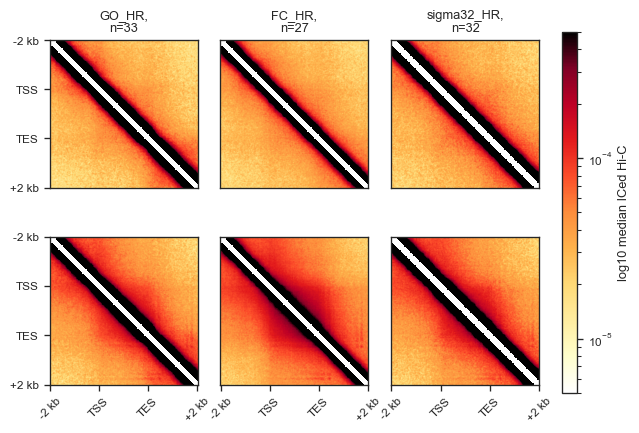

<Figure size 614.4x460.8 with 0 Axes>

In [21]:
import matplotlib.cm
import cooltools.lib.plotting
from matplotlib.ticker import EngFormatter

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.yaxis.tick_left()
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
sns.set_theme(context="paper", style='white', palette=susielu, font="Arial")
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplot_mosaic(
    """
    ABCG
    DEFG
    """
    ,figsize=(18*cm, 4*3.1*cm),gridspec_kw={'width_ratios':[1,1,1, 0.1]})

# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:

i = 0
norm = mpl.colors.LogNorm(vmin=0.000005, vmax=0.0005) 
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
ticks_pixels_borders = [0, 133, 266, 400]
ticks_borders = ['-2 kb', 'TSS', 'TES', '+2 kb']

for letter in ['A','B','C']:
    im = axs[letter].imshow(
        pup_wt.loc[i, 'data'],
        norm=norm,
        cmap='fall',
        interpolation='gaussian')
    format_ticks(axs[letter], rotate=True)
    if letter == "A":
        axs[letter].set(xticks=[], yticklabels=ticks_borders, 
                         yticks=ticks_pixels_borders, title="%s,\nn=%s" %(pup_median.HeatResponsegroup1[i], pup_median.n[i]),
                         #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
    else:
        axs[letter].set(xticks=[], title="%s,\nn=%s" %(pup_median.HeatResponsegroup1[i], pup_median.n[i]),
                        #xticklabels=ticks_kbp,
                        yticks=[])
    i += 1
    
i = 0
for letter in ['D','E','F']:
    im = axs[letter].imshow(
        pup_median.loc[i, 'data'],
        norm=norm,
        #vmin=0.000005, vmax=0.0005,
        cmap='fall',
        interpolation='gaussian')
    format_ticks(axs[letter], rotate=True)
    if letter == "D":
        axs[letter].set(xticks=ticks_pixels_borders, xticklabels=ticks_borders, yticklabels=ticks_borders, 
                         yticks=ticks_pixels_borders, #xlabel="\n".join(wrap('relative position, kbp', 25)), 
                         #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
    else:
        axs[letter].set(xticks=ticks_pixels_borders, xticklabels=ticks_borders,
                         yticks=[], #xlabel="\n".join(wrap('relative position, kbp', 25))
                       )
    i += 1 

cax = axs['G']
fig.colorbar(matplotlib.cm.ScalarMappable(norm, 'fall'), cax=cax, label = 'log10 median ICed Hi-C')

plt.savefig('results/HP_TU_hic.median.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.clf()

## ooe

In [10]:
flank = 2000
pup_44_ooe = coolpup.pileup(clr_44, sigma32_HR_TU_df.query('lengthBool_group == "long"'), 
                     groupby=['HeatResponsegroup1'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected_44,
                     flip_negative_strand=True,
                     flank=flank, min_diag=10, nproc=32,
                    mean_bool=False)

{'NC_000913.3'}


/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

In [11]:
flank = 2000
pup_wt_ooe = coolpup.pileup(clr, sigma32_HR_TU_df.query('lengthBool_group == "long"'), 
                     groupby=['HeatResponsegroup1'],
                     features_format='bed', 
                     view_df=view_df_chromsizes, local=True,
                     rescale=True, rescale_size=int(1+flank * 2// resolution),  
                     rescale_flank=1,
                     expected_df=expected,
                     flip_negative_strand=True,
                     flank=flank, min_diag=10, nproc=32,
                     mean_bool=False)

{'NC_000913.3'}


/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:762: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:765: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/coolpup.py:944: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

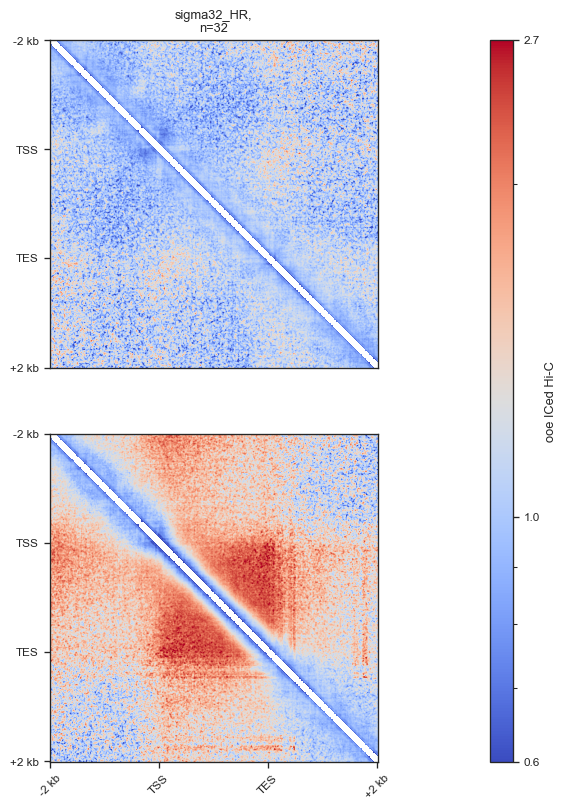

<Figure size 614.4x460.8 with 0 Axes>

In [35]:
import matplotlib.cm
import cooltools.lib.plotting
from matplotlib.ticker import EngFormatter
from matplotlib.ticker import FuncFormatter

# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
        ax.yaxis.tick_left()
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

# fmt = lambda x, pos: '{:.1g}'.format(x)#.split('e')
# fmt = '.3g'
# def fmt(x, pos):
#     a, b = '{:.1g}'.format(x).split('e')
#     b = int(b)
#     return r'${} \times 10^{{{}}}$'.format(a, b)
    
sns.set_theme(context="paper", style='white', palette=susielu, font="Arial")
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplot_mosaic(
    """
    AG
    DG
    """
    ,figsize=(18*cm, 8*3.1*cm),gridspec_kw={'width_ratios':[1, 0.05]})

# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:

i = 0
norm = mpl.colors.LogNorm(vmin=0.6, vmax=2.7) 
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
ticks_pixels_borders = [0, 133, 266, 400]
ticks_borders = ['-2 kb', 'TSS', 'TES', '+2 kb']

for letter in ['A']:
    im = axs[letter].imshow(
        pup_wt_ooe.loc[i, 'data'],
        norm=norm,
        cmap='coolwarm',
        interpolation='gaussian')
    format_ticks(axs[letter], rotate=True)
    if letter == "A":
        axs[letter].set(xticks=[], yticks=ticks_pixels_borders,
                        yticklabels=ticks_borders, 
                        title="%s,\nn=%s" %(pup_wt_ooe.HeatResponsegroup1[i], 
                                                                          pup_wt_ooe.n[i]),
                         #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       )
for letter in ['D']:
    im = axs[letter].imshow(
        pup_44_ooe.loc[i, 'data'],
        norm=norm,
        cmap='coolwarm',
        interpolation='gaussian')
    format_ticks(axs[letter], rotate=True)
    if letter == "D":
        axs[letter].set(xticks=ticks_pixels_borders, yticks=ticks_pixels_borders,
                        xticklabels=ticks_borders, yticklabels=ticks_borders, 
                          #xlabel="\n".join(wrap('relative position, kbp', 25)), 
                         #ylabel="\n".join(wrap('relative position from, kbp', 25))
                       ) 

cax = axs['G']
fig.colorbar(matplotlib.cm.ScalarMappable(norm, 'coolwarm'), ticks=[0.6, 1.0, 2.7],
             cax=cax, label = 'ooe ICed Hi-C',
            # format='%.1g'
            ) #format=FuncFormatter(fmt), , 
cax.set_yticklabels([0.6, 1.0, 2.7])
cax.set_yticklabels([], minor=True)
plt.savefig('results/HP_TU_hic.ooe.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.clf()

# Scatter

In [ ]:
TU_df['exp_group'] = 'zero'
TU_df.loc[TU_df[['nascent_wt44', 'nascent_wt']].sum(axis=1) > 0, 'exp_group'] = 'NotZero'
TU_df.query('exp_group == "NotZero"').head()

,chrom,start,end,TU_name,strand,GeneID,genes,ngenes,protein_codin,sigma,...,length,length_group,lengthBool_group,nascentCust_group,HeatResponsegroup,nascent_wt_CPM,nascent_wt44_CPM,FC,exp_group,CD_strength
1,NC_000913.3,1005952,1006494,zapC,+,operon_tu2,zapC,1,True,unknown,...,542,0,short,50-75%,no,0.704425,2.739011,3.833867,NotZero,0
2,NC_000913.3,1006491,1007600,ycbX,-,operon_tu3,ycbX,1,True,unknown,...,1109,2,long,bottom 50%,no,0.000000,0.288317,28.831692,NotZero,0
3,NC_000913.3,1007844,1011871,rlmL-uup,+,operon_tu4,rlmL;uup,2,True,unknown,...,4027,3,long,bottom 50%,no,0.234808,3.171486,12.954974,NotZero,0
4,NC_000913.3,1012001,1015459,pqiABC,+,operon_tu5,pqiA;pqiB;pqiC,3,True,sigma38,...,3458,3,long,75-90%,no,1.878467,2.739011,1.450389,NotZero,0
5,NC_000913.3,1015715,1015882,rmf,+,operon_tu6,rmf,1,True,unknown,...,167,0,short,75-90%,no,1.408850,1.153268,0.812818,NotZero,0


In [88]:
from coolpuppy import coolpup
from coolpuppy.lib.numutils import get_local_enrichment, get_domain_score
from coolpuppy.lib.puputils import accumulate_values
from coolpuppy import plotpup
def add_domain_mean(snippet):
    snippet['domain_mean'] = get_local_enrichment(snippet['data'], flank=1) # Calculates domain score for each snippet according to Flyamer et al., 2017
    return snippet

def add_domain_score(snippet):
    snippet['domain_score'] = get_domain_score(snippet['data']) # Calculates domain score for each snippet according to Flyamer et al., 2017
    return snippet

def extra_sum_func(dict1, dict2):
    return accumulate_values(dict1, dict2, 'domain_mean')
resolution = 10
flank=2000
# cc = coolpup.CoordCreator(TU_df.query('exp_group == "NotZero"'), resolution=resolution, features_format='bed', local=True, rescale_flank=1)
# pu = coolpup.PileUpper(clr, cc, view_df=view_df_chromsizes, ignore_diags=10, rescale_size=99, rescale=True, nproc=32) #expected=expected, 
pup = pu.pileupsWithControl(postprocess_func=add_domain_mean, # Any function can be applied to each snippet before they are averaged in the postprocess_func
                            extra_sum_funcs={'domain_mean': extra_sum_func}) # If additional values produced by postprocess_func need to be saved,
                                                                              # it can be done using the extra_sum_funcs dictionary, which defines how to combine them.
    
# pup = pu.pileupsWithControl(postprocess_func=add_domain_score, # Any function can be applied to each snippet before they are averaged in the postprocess_func
                            # extra_sum_funcs={'domain_score': extra_sum_func}) # If additional values produced by postprocess_func need to be saved,
#                                                                               # it can be done using the extra_sum_funcs dictionary, which defines how to combine them.



/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/lib/numutils.py:103: RuntimeWarning: Mean of empty slice
  return np.nanmean(amap[c:-c, c:-c])
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/lib/numutils.py:103: RuntimeWarning: Mean of empty slice
  return np.nanmean(amap[c:-c, c:-c])
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/coolpuppy/lib/numutils.py:103: RuntimeWarning: Mean of empty slice
  return np.nanmean(amap[c:-c, c:-c])


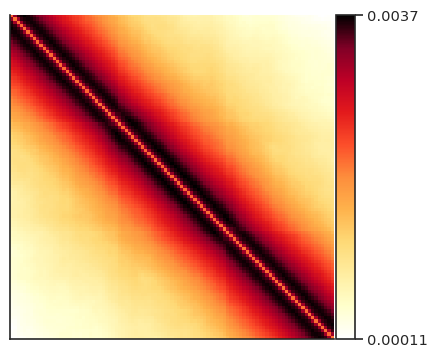

In [92]:
plotpup.plot(pup,
             score=False,
             cmap='fall',
             height=5, sym=False)

In [93]:
pup.loc[0, 'domain_mean'][:10]

[0.005508616729983017,
 0.00307491317304464,
 0.0016427150567488531,
 0.001890525924499848,
 0.0031526539312819474,
 0.0032122611670939564,
 0.004118750202347875,
 0.0008067808737661456,
 0.004382466433377107,
 0.0]

In [110]:
TU_df['CD_strength'] = 0
TU_df.query('exp_group == "NotZero" and end - start > 58').shape
# TU_df.loc[TU_df.exp_group == 'NotZero', 'CD_strength'].shape
# TU_df.head()

(2240, 24)

In [96]:
len(pup.loc[0, 'domain_mean'])

2239